# Figures for Schematic

## Get Embedding Coordinates for All Birds

### Imports

Use `pyemd_env`

In [1]:
import torchvision.datasets as datasets
import numpy as np
import os
import matplotlib.patches as patches
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

from emd import emd

In [2]:
import dask
from dask.distributed import Client

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
cuda = torch.cuda.is_available()
print(cuda)

True


In [4]:
import sys
sys.path.insert(0, "C:/Grad_School/Code_and_software/Py_code/similarity_scoring/syllable_triplet_network/siamese-triplet-scripts")
sys.path.insert(0, "C:/Grad_School/Code_and_software/Py_code/similarity_scoring/syllable_triplet_network/syllable_triplet_network")

In [5]:
# Set up network and training parameters
#from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector, HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector
from metrics import AverageNonzeroTripletsMetric
from datasets import BalancedBatchSampler

In [6]:
from custom_scripts.Therese_auto_mixed_precision_funcs import *
from custom_scripts.Therese_eval_funcs import *
from custom_scripts.Therese_inception_network_blocks import *
from custom_scripts.Therese_training_funcs import *

## Load Model

In [7]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3), nn.ReLU())
        self.MAM1 = InceptionBlock(32, 32, 16, 32, 16, 32, 16, 32)
        self.conv2 = nn.Sequential(nn.Conv2d(128, 64, kernel_size= 3, stride = (2, 1)), nn.ReLU())
        self.MAM2 = InceptionBlock(64, 32, 16, 32, 16, 32, 16, 32)
        self.conv3 = nn.Sequential(nn.Conv2d(128, 64, 3, stride = (2, 1)), nn.ReLU())
        self.MAM3 = InceptionBlock(64, 32, 16, 32, 16, 32, 16, 32)
        self.conv4 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, stride = (2, 1)), nn.ReLU())
        self.MAM4 = InceptionBlock(64, 32, 16, 32, 16, 32, 16, 32)
        self.conv5 = nn.Sequential(nn.Conv2d(128, 64, 3, stride = (2, 1)), nn.ReLU())
        
        #self.global_pool = nn.AvgPool2d(kernel_size= ) the global pooling reduces the output to a vector of length 64. 
            #to figure out the kernel size necessary to do that I need to know the dimensions of the input and I currently have no clue what that would be

        self.global_pool = nn.AvgPool2d(kernel_size = (1, 4), stride = 4)

        self.fc = nn.Sequential(nn.Linear(960, 256),
                                nn.ReLU(),
                                 
                                nn.Linear(256, 128),
                                nn.ReLU(),
                                 
                                nn.Linear(128, 8)
                                )


    def forward(self, x):
        x = torch.unsqueeze(x, 1).float()
        x = self.conv1(x)
        x = self.MAM1(x)
        x = self.conv2(x)
        x = self.MAM2(x)
        x = self.conv3(x)
        x = self.MAM3(x)
        x = self.conv4(x)
        x = self.MAM4(x)
        x = self.conv5(x)
    
        x = self.global_pool(x)
        x = x.view(x.size()[0], -1)

        x = self.fc(x)

        x = F.normalize(x, p = 2, dim = 1)
        

        return x
        
    def get_embedding(self, x):
        return self.forward(x)

In [8]:
model = torch.load("C:/Grad_School/Code_and_software/Py_code/similarity_scoring/syllable_triplet_network/trained_models/53_emd_July_22_02.pt")

### Load Bird Data

In [9]:
pairs_df = pd.read_csv("C:/Grad_School/Code_and_software/Py_code/similarity_scoring/tut_pupil_pairs_April_2022.csv")

pairs_df = pairs_df[pairs_df.Include == 1]

In [15]:
pairs_df.shape

(36, 4)

In [10]:
tut_pup_dir = 'D:\\Final_Bird_Dataset\\Wseg_syll_spects_for_similarity\\'

### Get Embeddings

In [49]:
all_comparisons = pd.DataFrame()
all_emds_computed = []

n_dim = 8

for index, row in pairs_df[:].iterrows():
    Bird_ID = row.Bird_ID
    Tut_ID = row.Tutor_ID
    print(Bird_ID)

    #compute embedding for current bird
    curr_bird_embedding, curr_bird_labels = single_bird_extract_embeddings(Bird_ID, tut_pup_dir, model, n_dim=n_dim)

    curr_bird_embedding = pd.DataFrame(curr_bird_embedding)
    curr_bird_embedding.to_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Bird_ID + "_embeddings.csv")
        

G402
R402
G555
R629
Y653
G587
B555
O510
B447
S389
Y389
O421
S421
B402
Y433
O434
R469
S525
G413
G528
S528
G668
R509
Y354
G592
B573
R623
Y561
S561
Y654
O630
S565
B646
O670
R646
S636


In [50]:
n_dim = 8

for Tutor_ID in pairs_df.Tutor_ID.unique():
    #compute embedding for current bird's tutor
    curr_tut_embedding, curr_tut_labels = single_bird_extract_embeddings(Tut_ID, tut_pup_dir, model, n_dim=n_dim)

    curr_bird_embedding = pd.DataFrame(curr_bird_embedding)
    curr_bird_embedding.to_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Tutor_ID + "_embeddings.csv")

In [12]:
tut_pup_dir = 'D:\\Final_Bird_Dataset\\Wseg_syll_spects_for_similarity_full\\'
n_dim = 8

for Bird_ID in ['B555','G668', 'O314']:

    print(Bird_ID)

    #compute embedding for current bird
    curr_bird_embedding, curr_bird_labels = single_bird_extract_embeddings(Bird_ID, tut_pup_dir, model, n_dim=n_dim)

    curr_bird_embedding = pd.DataFrame(curr_bird_embedding)
    curr_bird_embedding.to_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Bird_ID + "_embeddings.csv")


B555
G668
O314


# Plot PCA of Embeddings

In [32]:
Bird_ID = 'G402'

curr_bird_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Bird_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')

In [11]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA(n_components = 2)
embeddings_2D = pca.fit_transform(curr_bird_embeddings.values)

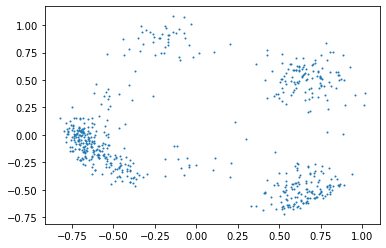

In [44]:
plt.scatter(embeddings_2D[:, 0], embeddings_2D[:, 1], s = 1)

In [12]:
pca = PCA(n_components = 2)

In [13]:
for index, row in pairs_df[:].iterrows():
    Bird_ID = row.Bird_ID
    Tut_ID = row.Tutor_ID
    print(Bird_ID)

    pup_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Bird_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')
    tut_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Tut_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')

    pca.fit(np.concatenate([pup_embeddings.values, tut_embeddings.values]))
    pup_2D = pca.transform(pup_embeddings.values)
    tut_2D = pca.transform(tut_embeddings.values)

    plt.scatter(pup_2D[:, 0], pup_2D[:, 1], s = 1)
    plt.scatter(tut_2D[:, 0], tut_2D[:, 1], s = 1, alpha = 0.3)
    plt.title(Bird_ID)
    plt.show()

NameError: name 'pairs_df' is not defined

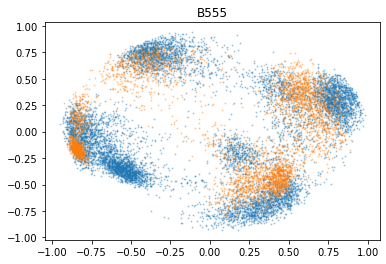

In [14]:
Bird_ID = 'B555'
Tut_ID = 'O314'


pup_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Bird_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')
tut_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Tut_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')

pca.fit(np.concatenate([pup_embeddings.values, tut_embeddings.values]))
pup_2D = pca.transform(pup_embeddings.values)
tut_2D = pca.transform(tut_embeddings.values)

plt.scatter(pup_2D[:, 0], pup_2D[:, 1], s = 1, alpha = 0.3)
plt.scatter(tut_2D[:, 0], tut_2D[:, 1], s = 1, alpha = 0.3)
plt.title(Bird_ID)
plt.show()

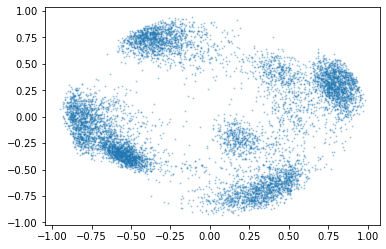

In [15]:
plt.scatter(pup_2D[:, 0], pup_2D[:, 1], s = 1, alpha = 0.3)

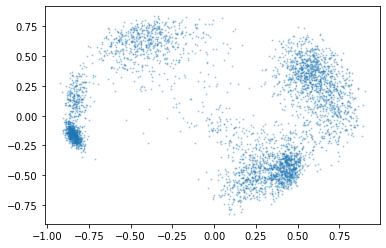

In [16]:
plt.scatter(tut_2D[:, 0], tut_2D[:, 1], s = 1, alpha = 0.3)

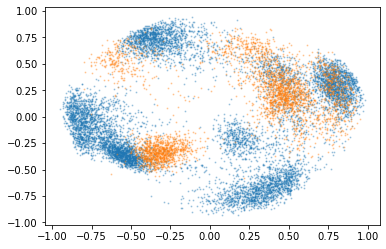

In [17]:
unrelated = 'G668'
unrelated_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + unrelated + "_embeddings.csv").drop(columns = 'Unnamed: 0')
unrelated_2D = pca.transform(unrelated_embeddings.values)

plt.scatter(pup_2D[:, 0], pup_2D[:, 1], s = 1, alpha = 0.3)
plt.scatter(unrelated_2D[:, 0], unrelated_2D[:, 1], s = 1, alpha = 0.3)

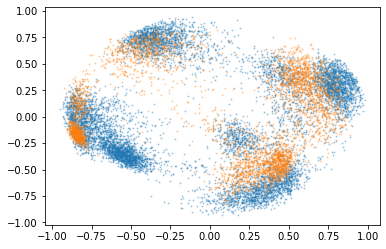

In [18]:
plt.scatter(pup_2D[:, 0], pup_2D[:, 1], s = 1, alpha = 0.3)
plt.scatter(tut_2D[:, 0], tut_2D[:, 1], s = 1, alpha = 0.3)

# Plot Individual Syllables in PCA


## Imports

In [1]:
import avn.plotting 
import avn.dataloading 
from avn.plotting import make_spectrogram
from avn.plotting import plot_spectrogram
import matplotlib.patches as mpatches
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

In [2]:
def select_syll(song, onset, offset, padding = 0):
    
    padded_onset = max(0, onset - padding)
    onset_correction_diff = (onset - padding) - padded_onset
    
    padded_offset = min(offset + padding, song.duration)
    offset_correction_diff = (offset + padding) - padded_offset
    
    on_index = int(padded_onset * song.sample_rate)
    off_index = int(padded_offset * song.sample_rate)

    syll_data = song.data[on_index:off_index]
    return syll_data, onset_correction_diff, offset_correction_diff

In [3]:
def plot_spect(syll_table_row, padding, song_folder_path, figsize, save_file_path = None):
    #load file for subject syllable
    file_path = song_folder_path + syll_table_row.file
    song = avn.dataloading.SongFile(file_path)
    song.bandpass_filter(500, 15000)
    
    
    onset = syll_table_row.onset
    offset = syll_table_row.offset
    syll_data, onset_correction, offset_correction = select_syll(song, onset, offset, padding = padding)
    
    song.data = syll_data

    dur = offset - onset
    
    spectrogram = avn.plotting.make_spectrogram(song)
    spectrogram = spectrogram[:200]
    
    #print(spectrogram.shape)
    print(song.duration)
    
    
    fig, ax = plt.subplots(figsize = (dur * 5, 1))
    img = librosa.display.specshow(spectrogram, sr = song.sample_rate, 
                             hop_length = 512 / 4, 
                             x_axis = 'time', 
                             y_axis = 'hz', 
                             cmap = 'viridis', 
                             ax = ax, vmin = 55)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    #ax.set_title(syll_table_row.Bird_ID + "  " + syll_table_row.files)
    
    new_onset = xmin + padding + onset_correction
    new_offset = xmax - padding + offset_correction
    
    #ax.add_patch(mpatches.Rectangle(
     #               [new_onset, ymax - (ymax - ymin) / 10],
      #              new_offset - new_onset,
       #             (ymax - ymin) / 10,
        #            ec="none",
         #           color='red'))

    if save_file_path is not None:
        fig.savefig(save_file_path,)
    
    
    return spectrogram, song.sample_rate, song.data, ymin, ymax, onset, offset, onset_correction, offset_correction

### B555

In [54]:
Bird_ID = 'B555'

song_folder_path = "C:/Grad_School/Song_Data/similarity_tut_pup_dataset/Pupil_Songs/" + Bird_ID + "/all_songs/"
segmentations_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + "_wseg.csv"
segmentations = pd.read_csv(segmentations_path).drop(columns = 'Unnamed: 0')

In [55]:
from sklearn.decomposition import PCA

In [56]:
Bird_ID = 'B555'
Tut_ID = 'O314'

pca = PCA(n_components = 2)

pup_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Bird_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')
tut_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Tut_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')

pca.fit(np.concatenate([pup_embeddings.values, tut_embeddings.values]))
pup_2D = pca.transform(pup_embeddings.values)
tut_2D = pca.transform(tut_embeddings.values)

In [57]:
pup_2D.shape

(8622, 2)

In [58]:
segmentations.shape

(8622, 4)

In [59]:
segmentations['X'] = pup_2D[:, 0]
segmentations['Y'] = pup_2D[:, 1]

In [60]:
segmentations.head()

onset  offset        cluster                                  file  \
0  0.008   0.133  zebra_finch_0  B555_44337.25064975_5_21_6_57_44.wav   
1  0.163   0.218  zebra_finch_0  B555_44337.25064975_5_21_6_57_44.wav   
2  0.247   0.498  zebra_finch_0  B555_44337.25064975_5_21_6_57_44.wav   
3  0.513   0.605  zebra_finch_0  B555_44337.25064975_5_21_6_57_44.wav   
4  0.618   0.797  zebra_finch_0  B555_44337.25064975_5_21_6_57_44.wav   

          X         Y  
0 -0.226434 -0.043004  
1  0.851713 -0.128346  
2  0.217711 -0.715804  
3 -0.327936  0.807629  
4 -0.729869 -0.218688

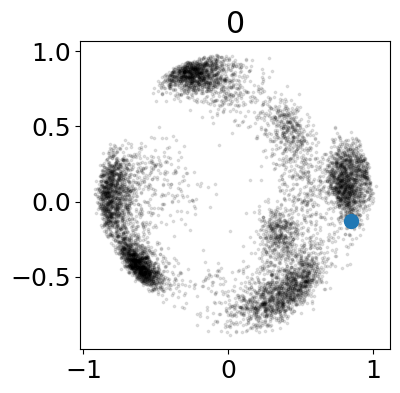

12.004716553287983


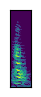

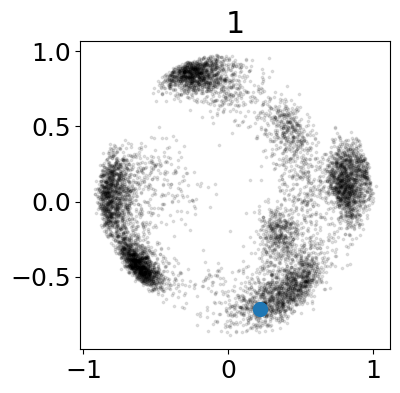

12.004716553287983


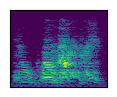

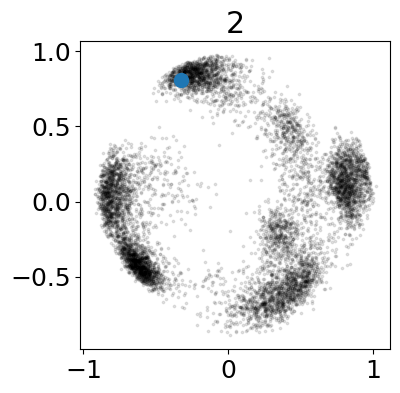

12.004716553287983


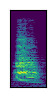

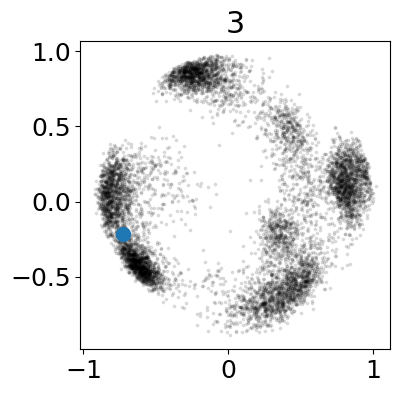

12.004716553287983


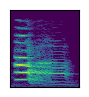

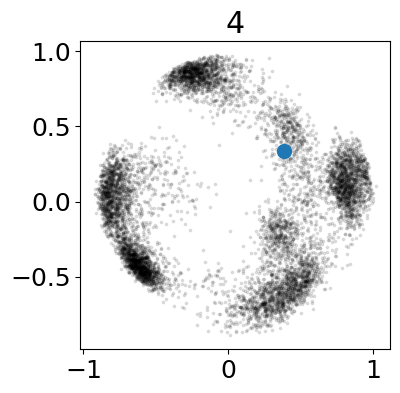

12.004716553287983


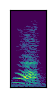

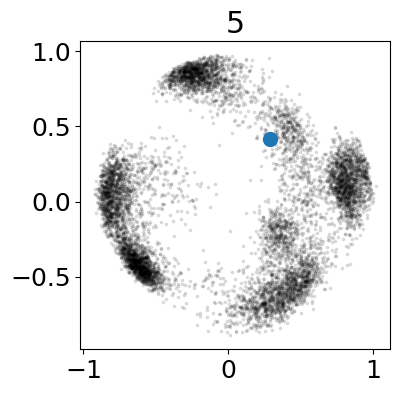

12.004716553287983


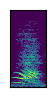

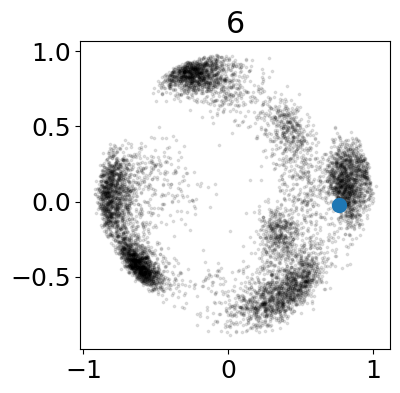

12.004716553287983


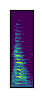

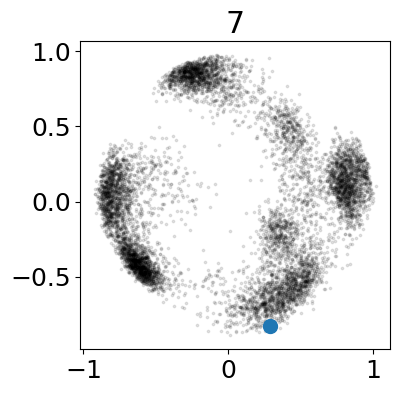

12.004716553287983


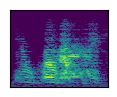

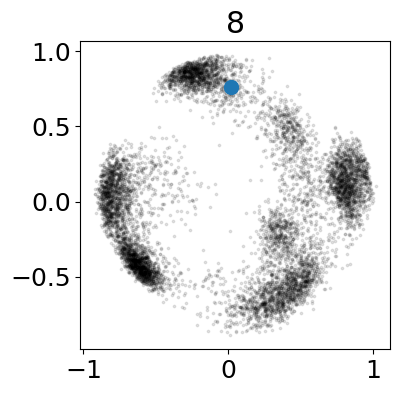

12.004716553287983


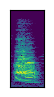

In [61]:
subset_df = segmentations.iloc[1:10]


for i, row in enumerate(subset_df.itertuples()):
    plt.figure(figsize = (4, 4))

    plt.scatter(segmentations.X, segmentations.Y, color = 'black', alpha = 0.1, s = 3)
    plt.scatter(subset_df.X.iloc[i], subset_df.Y.iloc[i], s = 100)
    plt.title(str(i))
    plt.show()

    save_file_path = Bird_ID + "_example_syll_" + str(i) + ".png"
    spectrogram = plot_spect(row, padding = 0.01, song_folder_path=song_folder_path, figsize = (1.25, 1.25), )

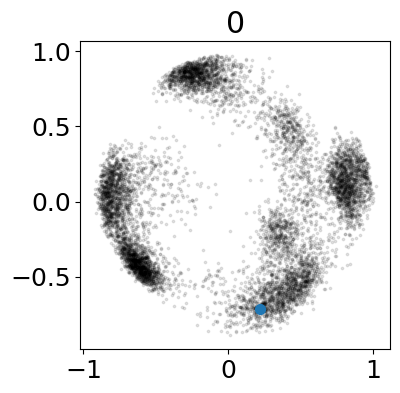

12.004716553287983


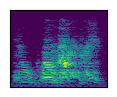

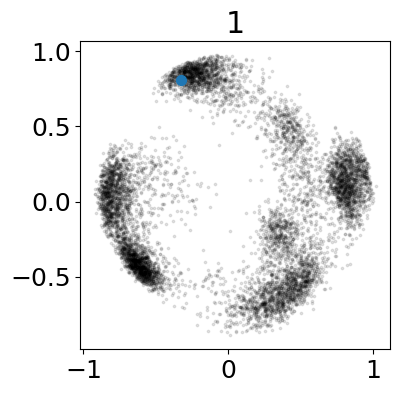

12.004716553287983


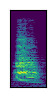

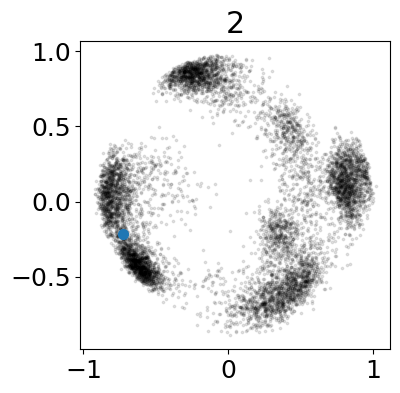

12.004716553287983


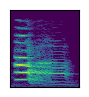

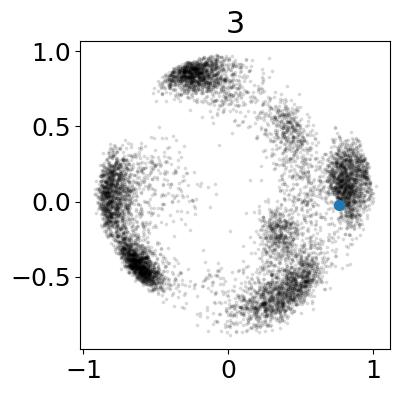

12.004716553287983


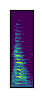

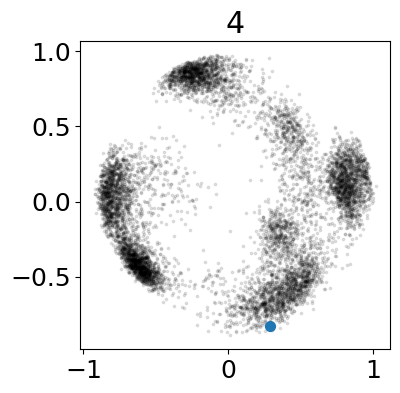

12.004716553287983


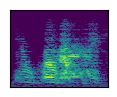

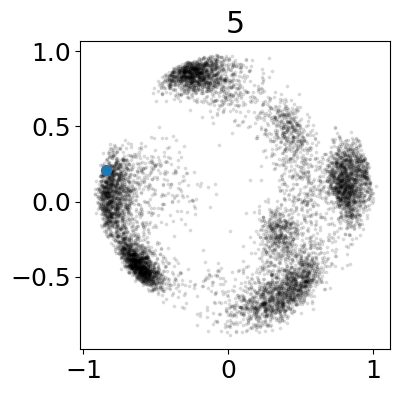

12.004716553287983


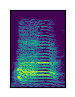

In [62]:
subset_df = segmentations.iloc[[2, 3, 4, 7, 8, 17]]


for i, row in enumerate(subset_df.itertuples()):
    plt.figure(figsize = (4, 4))

    plt.scatter(segmentations.X, segmentations.Y, color = 'black', alpha = 0.1, s = 3)
    plt.scatter(subset_df.X.iloc[i], subset_df.Y.iloc[i], s = 50)
    plt.title(str(i))
    plt.show()

    save_file_path = Bird_ID + "_example_syll_" + str(i) + ".svg"
    spectrogram = plot_spect(row, padding = 0.01, song_folder_path=song_folder_path, figsize = (1.25, 1.25), 
                            save_file_path = save_file_path)

In [63]:
plt.rcParams.update({'font.size': 18})

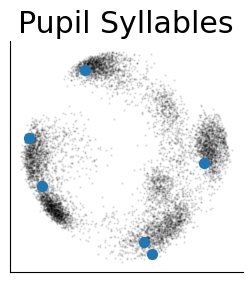

In [64]:
plt.figure(figsize = (3, 3))
plt.scatter(segmentations.X, segmentations.Y, color = 'black', alpha = 0.1, s = 0.5)
plt.scatter(subset_df.X, subset_df.Y, s = 50)
sns.despine()
plt.xticks([])
plt.yticks([])
plt.title('Pupil Syllables')
plt.savefig('poster_B555_embeddings.svg', transparent = True)


## O314

In [65]:
Bird_ID = 'O314'

song_folder_path = "C:/Grad_School/Song_Data/similarity_tut_pup_dataset/Tutor_Songs/" + Bird_ID + "/all_songs/"
segmentations_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + "_wseg.csv"
segmentations = pd.read_csv(segmentations_path).drop(columns = 'Unnamed: 0')

In [66]:
from sklearn.decomposition import PCA

In [67]:
Bird_ID = 'B555'
Tut_ID = 'O314'

pca = PCA(n_components = 2)

pup_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Bird_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')
tut_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Tut_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')

pca.fit(np.concatenate([pup_embeddings.values, tut_embeddings.values]))
pup_2D = pca.transform(pup_embeddings.values)
tut_2D = pca.transform(tut_embeddings.values)

In [68]:
tut_2D.shape

(2110, 2)

In [69]:
segmentations.shape

(2110, 4)

In [70]:
segmentations['X'] = tut_2D[:, 0]
segmentations['Y'] = tut_2D[:, 1]

In [71]:
segmentations.head()

onset  offset        cluster                                   file  \
0  0.010   0.138  zebra_finch_0  O314_43823.19696848_12_24_5_28_16.wav   
1  0.177   0.348  zebra_finch_0  O314_43823.19696848_12_24_5_28_16.wav   
2  0.373   0.548  zebra_finch_0  O314_43823.19696848_12_24_5_28_16.wav   
3  0.572   0.748  zebra_finch_0  O314_43823.19696848_12_24_5_28_16.wav   
4  0.777   0.957  zebra_finch_0  O314_43823.19696848_12_24_5_28_16.wav   

          X         Y  
0 -0.204204 -0.100114  
1 -0.794305  0.000359  
2 -0.794293 -0.081527  
3 -0.781888 -0.192200  
4 -0.771391 -0.084980

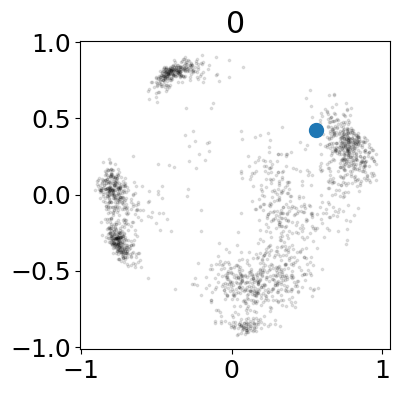

12.051156462585034


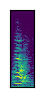

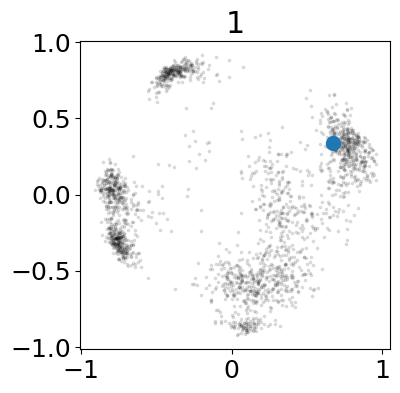

12.051156462585034


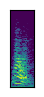

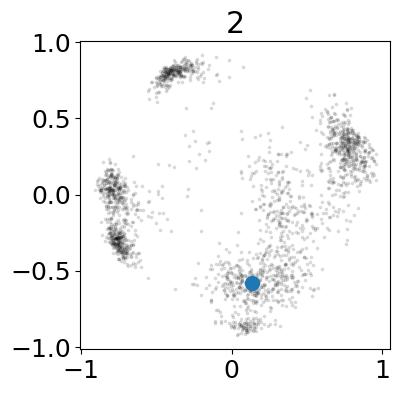

12.051156462585034


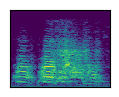

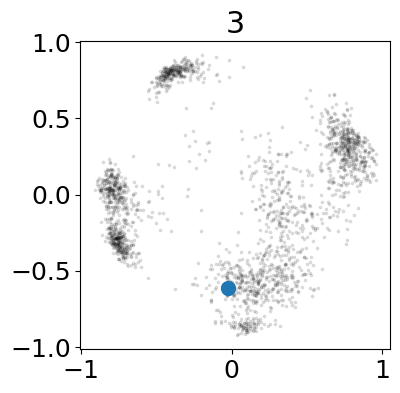

12.051156462585034


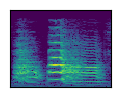

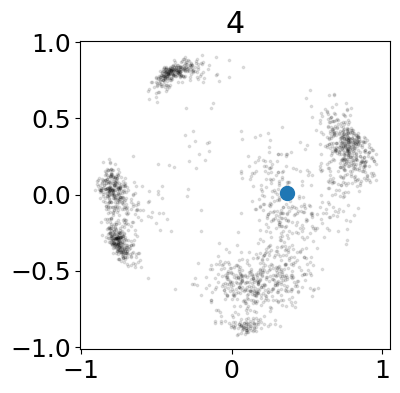

12.051156462585034


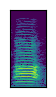

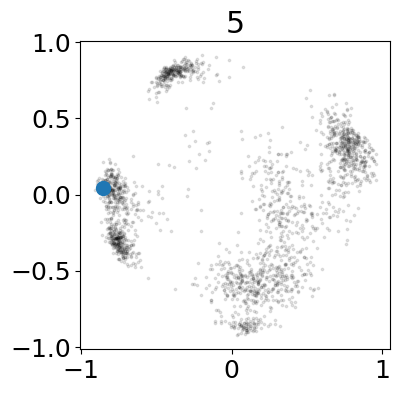

12.051156462585034


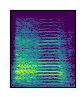

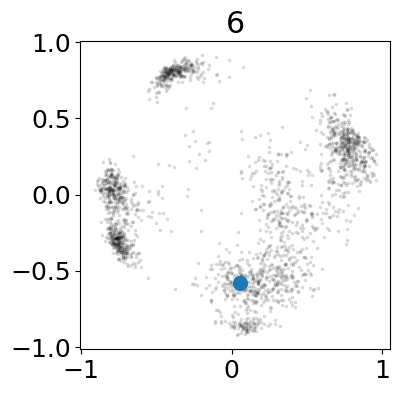

12.051156462585034


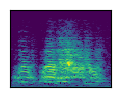

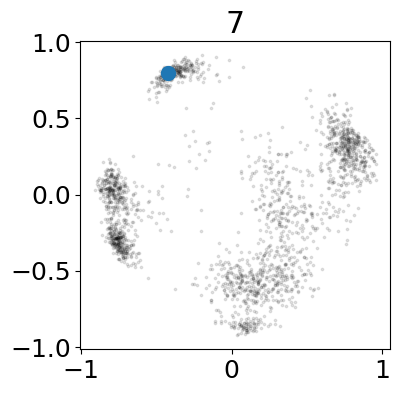

12.051156462585034


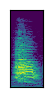

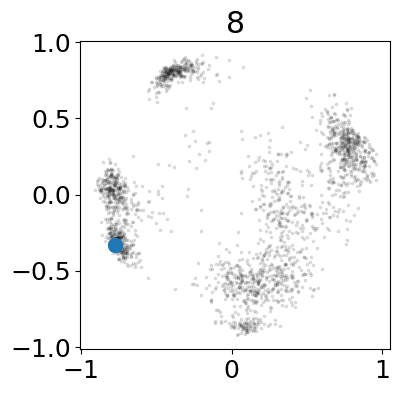

12.051156462585034


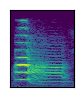

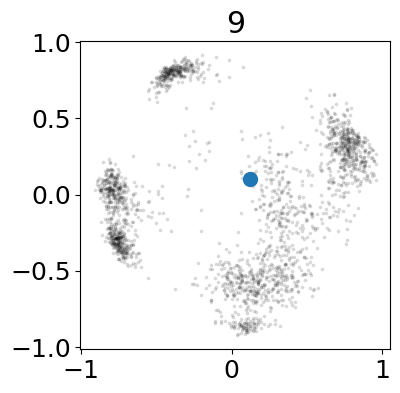

12.051156462585034


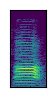

In [72]:
subset_df = segmentations.iloc[20:30]


for i, row in enumerate(subset_df.itertuples()):
    plt.figure(figsize = (4, 4))

    plt.scatter(segmentations.X, segmentations.Y, color = 'black', alpha = 0.1, s = 3)
    plt.scatter(subset_df.X.iloc[i], subset_df.Y.iloc[i], s = 100)
    plt.title(str(i))
    plt.show()

    save_file_path = Bird_ID + "_example_syll_" + str(i) + ".png"
    spectrogram = plot_spect(row, padding = 0.01, song_folder_path=song_folder_path, figsize = (1.25, 1.25), )

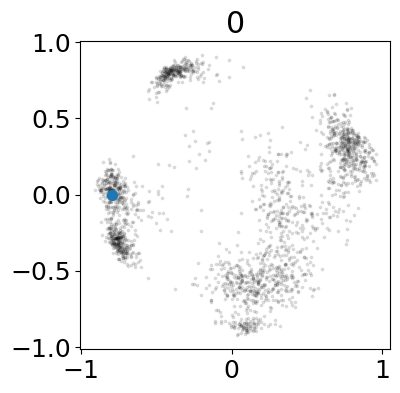

4.899410430839002


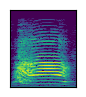

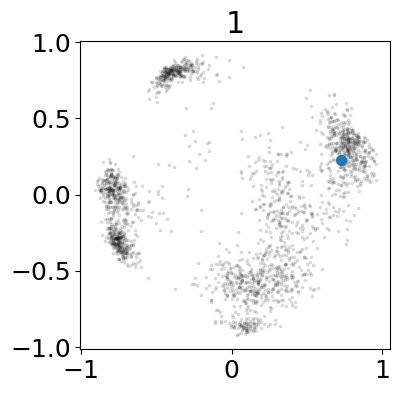

12.051156462585034


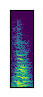

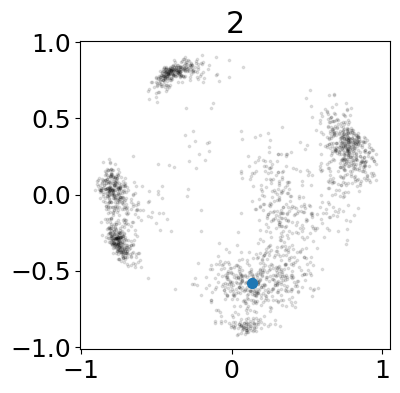

12.051156462585034


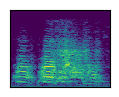

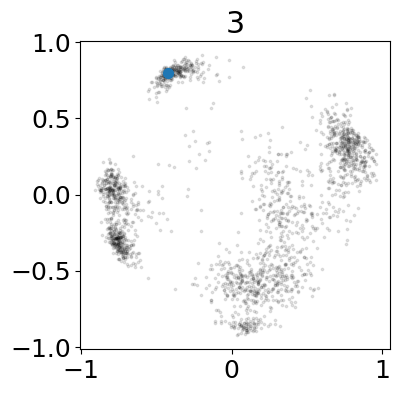

12.051156462585034


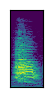

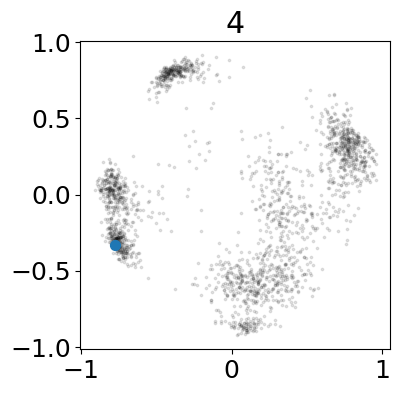

12.051156462585034


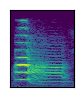

In [73]:
subset_df = segmentations.iloc[[1, 14, 22, 27, 28]]


for i, row in enumerate(subset_df.itertuples()):
    plt.figure(figsize = (4, 4))

    plt.scatter(segmentations.X, segmentations.Y, color = 'black', alpha = 0.1, s = 3)
    plt.scatter(subset_df.X.iloc[i], subset_df.Y.iloc[i], s = 50)
    plt.title(str(i))
    plt.show()

    save_file_path = Tut_ID + "_example_syll_" + str(i) + ".svg"
    spectrogram = plot_spect(row, padding = 0.01, song_folder_path=song_folder_path, figsize = (1.25, 1.25), 
                            save_file_path = save_file_path)

In [74]:
plt.rcParams.update({'font.size': 18})

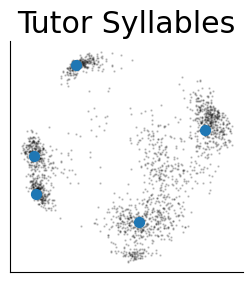

In [76]:
plt.figure(figsize = (3, 3))
plt.scatter(segmentations.X, segmentations.Y, color = 'black', alpha = 0.2, s = 0.5)
plt.scatter(subset_df.X, subset_df.Y, s = 50)
sns.despine()
plt.xticks([])
plt.yticks([])
plt.title('Tutor Syllables')
plt.savefig('poster_O314_embeddings.svg', transparent = True)


## G668

In [77]:
Bird_ID = 'G668'

song_folder_path = "C:/Grad_School/Song_Data/similarity_tut_pup_dataset/Pupil_Songs/" + Bird_ID + "/all_songs/"
segmentations_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + "_wseg.csv"
segmentations = pd.read_csv(segmentations_path).drop(columns = 'Unnamed: 0')

In [79]:
Bird_ID = 'B555'
Tut_ID = 'O314'

curr_bird = 'G668'

pca = PCA(n_components = 2)

pup_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Bird_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')
tut_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + Tut_ID + "_embeddings.csv").drop(columns = 'Unnamed: 0')
curr_bird_embeddings = pd.read_csv("D:\\Final_Bird_Dataset\\similarity_embeddings\\" + curr_bird + "_embeddings.csv").drop(columns = 'Unnamed: 0')

pca.fit(np.concatenate([pup_embeddings.values, tut_embeddings.values]))
pup_2D = pca.transform(pup_embeddings.values)
tut_2D = pca.transform(tut_embeddings.values)
curr_bird_2d = pca.transform(curr_bird_embeddings.values)

In [81]:
segmentations['X'] = curr_bird_2d[:, 0]
segmentations['Y'] = curr_bird_2d[:, 1]

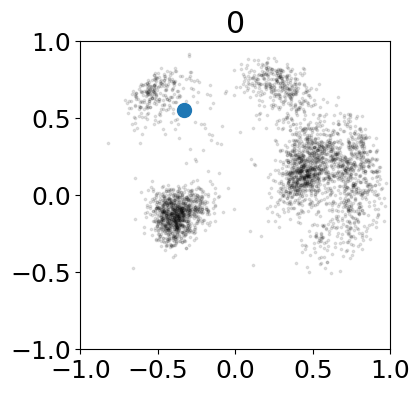

8.928072562358278


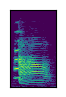

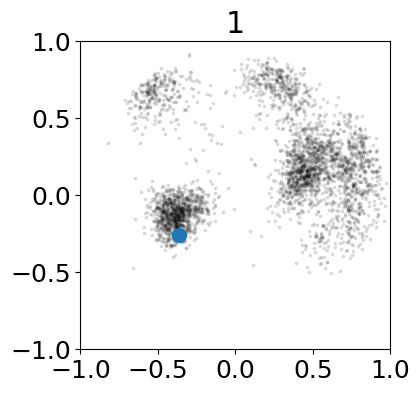

8.928072562358278


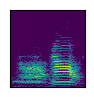

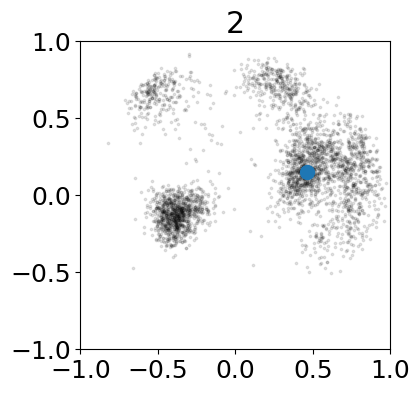

8.928072562358278


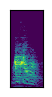

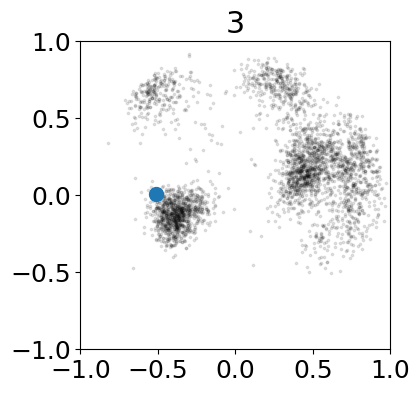

8.928072562358278


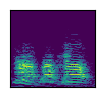

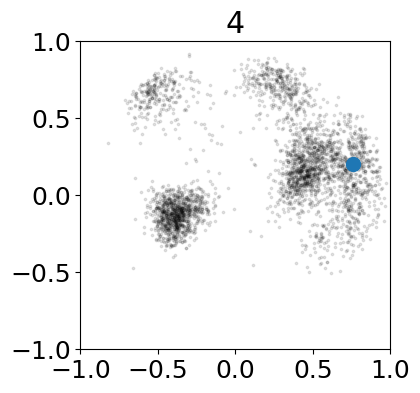

8.928072562358278


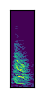

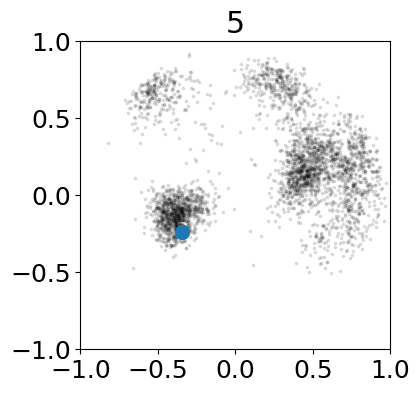

8.928072562358278


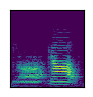

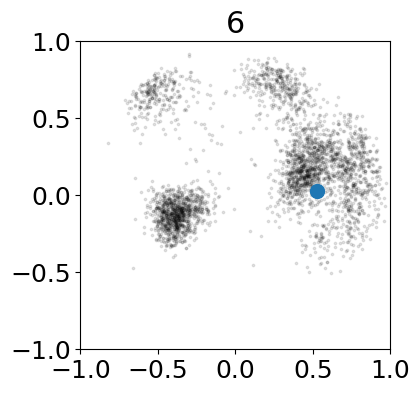

8.928072562358278


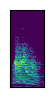

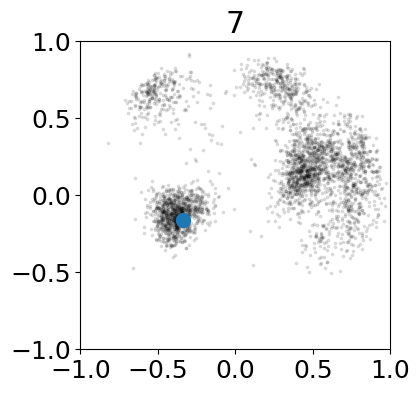

8.928072562358278


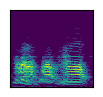

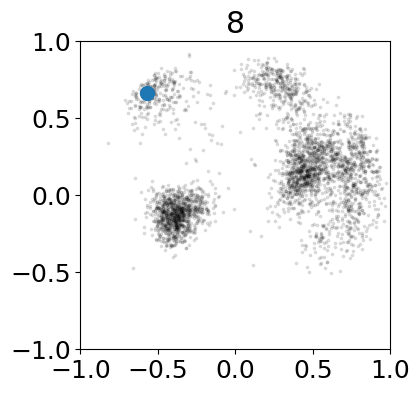

8.928072562358278


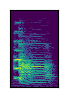

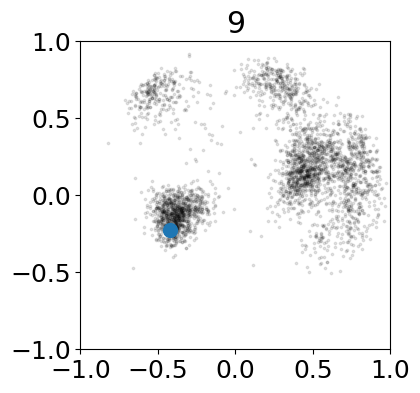

8.928072562358278


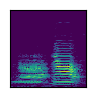

In [88]:
subset_df = segmentations.iloc[30:40]


for i, row in enumerate(subset_df.itertuples()):
    plt.figure(figsize = (4, 4))

    plt.scatter(segmentations.X, segmentations.Y, color = 'black', alpha = 0.1, s = 3)
    plt.scatter(subset_df.X.iloc[i], subset_df.Y.iloc[i], s = 100)
    plt.title(str(i))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()
    

    save_file_path = curr_bird + "_example_syll_" + str(i) + ".png"
    spectrogram = plot_spect(row, padding = 0.01, song_folder_path=song_folder_path, figsize = (1.25, 1.25), )

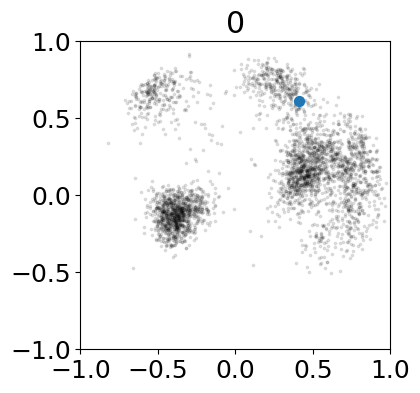

3.982222222222222


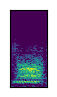

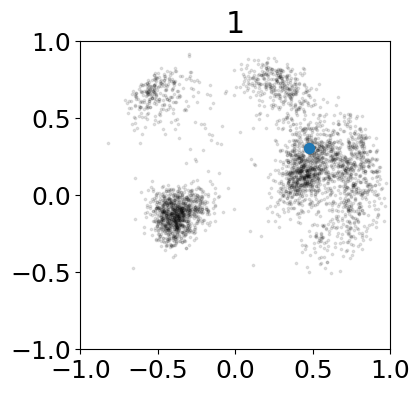

3.982222222222222


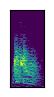

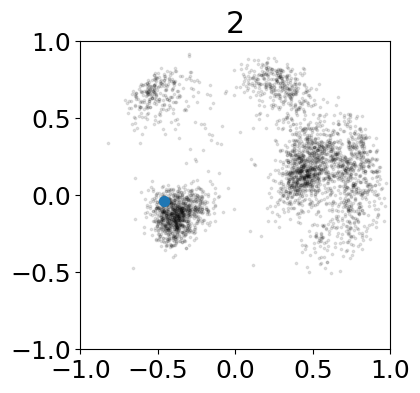

3.982222222222222


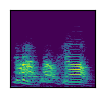

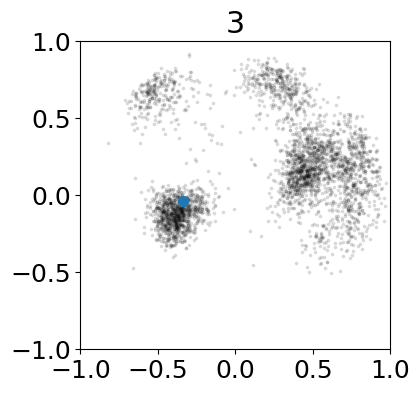

8.928072562358278


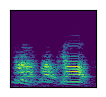

8.928072562358278


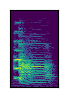

In [91]:
subset_df = segmentations.iloc[[7, 9, 10, 29, 38]]


for i, row in enumerate(subset_df.itertuples()):
    plt.figure(figsize = (4, 4))

    plt.scatter(segmentations.X, segmentations.Y, color = 'black', alpha = 0.1, s = 3)
    plt.scatter(subset_df.X.iloc[i], subset_df.Y.iloc[i], s = 50)
    plt.title(str(i))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

    save_file_path = curr_bird + "_example_syll_" + str(i) + ".svg"
    spectrogram = plot_spect(row, padding = 0.01, song_folder_path=song_folder_path, figsize = (1.25, 1.25), 
                            save_file_path = save_file_path)

In [92]:
plt.figure(figsize = (3, 3))
plt.scatter(segmentations.X, segmentations.Y, color = 'black', alpha = 0.1, s = 0.5)
plt.scatter(subset_df.X, subset_df.Y, s = 50)
sns.despine()
plt.xticks([])
plt.yticks([])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Unrelated Bird\nSyllables')
plt.savefig('poster_G668_embeddings.svg', transparent = True)

## Overlapping Distributions

In [94]:
len(pup_2D)/2

4311.0

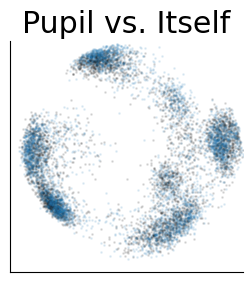

In [104]:
plt.figure(figsize = (3, 3))
plt.scatter(pup_2D[:4311, 0], pup_2D[:4311, 1], color = 'black', alpha = 0.1, s = 1)
plt.scatter(pup_2D[4311:, 0], pup_2D[4311:, 1], s = 1, alpha = 0.1, color = sns.color_palette()[0])
sns.despine()
plt.xticks([])
plt.yticks([])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Pupil vs. Itself')
plt.savefig('poster_pupil_v_itself.svg',transparent = True)

In [105]:
plt.figure(figsize = (3, 3))
plt.scatter(pup_2D[:, 0], pup_2D[:, 1], color = 'black', alpha = 0.1, s = 1)
plt.scatter(tut_2D[:, 0], tut_2D[:, 1], s = 1, alpha = 0.2, color = sns.color_palette()[1])
sns.despine()
plt.xticks([])
plt.yticks([])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Pupil vs. Tutor')
plt.savefig('poster_pupil_v_Tutor.svg',transparent = True)

In [106]:
plt.figure(figsize = (3, 3))
plt.scatter(pup_2D[:, 0], pup_2D[:, 1], color = 'black', alpha = 0.1, s = 1)
plt.scatter(curr_bird_2d[:, 0], curr_bird_2d[:, 1], s = 1, alpha = 0.2, color = sns.color_palette()[3])
sns.despine()
plt.xticks([])
plt.yticks([])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Pupil vs. Unrelated')
plt.savefig('poster_pupil_v_unrelated.svg',transparent = True)